In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataset

import numpy as np
import matplotlib.pyplot as plt

# 1. Seq2seq

**Seq2seq (Sequence to Sequence)** is an RNN encoder-decoder framework for **Neural Machine Translation**, or more generally **Sequence Transduction**, specifically by encoding a variable-length source sentence into a fixed-shape vector. The latter would then be decoded into a variable-length target sentence. 
- [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078)
- [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215) by Ilya Sutskever & Quoc Le at Google Brain

Conventionally, in an RNN all relevant information about a source sequence is translated into some internal fixed-dimensional state representation by the encoder. It is this very state that is used by the decoder as the complete and exclusive source of information for generating the translated sequence. In other words, the sequence-to-sequence mechanism treats the intermediate state as a sufficient statistic of whatever string might have served as input.

# 2. Attention Mechanisms
## 2-1. Neural Machine Translation with Bahdanau Attention
1. `torch.utils.data.RandomSampler(data_source, replacement=False, num_samples=None, generator=None)`: Samples elements randomly. If without replacement, then sample from a shuffled dataset.

The dataset is derived from the open translation website, [Tatoeba Project](https://tatoeba.org/en), and [Tab-Delimited Bilingual Sentence Pairs](https://www.manythings.org/anki/) splitting languages into individual text files. We will trim the dataset to only relatively short & simple sentences by setting the maximum length. 

In [2]:
import unicodedata, re

# Turn a Unicode string to plain ASCII
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters
def normalize_string(string):
    string = unicode_to_ascii(string.lower().strip())
    string = re.sub(r"([.!?])", r" \1", string)
    string = re.sub(r"[^a-zA-Z!?]+", r" ", string)
    return string.strip()

max_length = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filter_pair(pair):
    return len(pair[0].split(' ')) < max_length and len(pair[1].split(' ')) < max_length and pair[1].startswith(eng_prefixes)

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

In [3]:
sos_token = 0
eos_token = 1

class Language:
    def __init__(self, name):
        self.name = name
        self.word2idx = {}
        self.word_count = {}
        self.idx2word = {0: "<SOS>", 1: "<EOS>"}
        # Count `<SOS>` & `<EOS>`
        self.num_words = 2

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.num_words
            self.word_count[word] = 1
            self.idx2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word_count[word] += 1

def read_languages(language_1, language_2, reverse=False):
    print("Reading Lines...")

    # Read the file and split into lines
    lines = open('datasets/name_languages/%s-%s.txt' % (language_1, language_2), encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make `Language` instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_language = Language(language_2)
        output_language = Language(language_1)
    else:
        input_language = Language(language_1)
        output_language = Language(language_2)

    return input_language, output_language, pairs

In [4]:
import random

random.seed(0)

def prepare_data(language_1, language_2, reverse=False):
    input_language, output_language, pairs = read_languages(language_1, language_2, reverse)
    print("Read %s sentence pairs." % len(pairs))
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs." % len(pairs))
    print("Counting Words...")
    for pair in pairs:
        input_language.add_sentence(pair[0])
        output_language.add_sentence(pair[1])
    print("Counted Words:")
    print(input_language.name, input_language.num_words)
    print(output_language.name, output_language.num_words)
    return input_language, output_language, pairs

input_language, output_language, pairs = prepare_data('eng', 'fra', True)
print(random.choice(pairs))

Reading Lines...
Read 135842 sentence pairs.
Trimmed to 11445 sentence pairs.
Counting Words...
Counted Words:
fra 4601
eng 2991
['nous sommes du meme cote', 'we re on the same side']


In [29]:
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

def indexes_from_sentence(language, sentence):
    return [language.word2idx[word] for word in sentence.split(' ')]

def tensor_from_sentence(language, sentence):
    indexes = indexes_from_sentence(language, sentence)
    indexes.append(eos_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensors_from_pair(pair):
    input_tensor = tensor_from_sentence(input_language, pair[0])
    target_tensor = tensor_from_sentence(output_language, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_language, output_language, pairs = prepare_data('eng', 'fra', True)

    num_pairs = len(pairs)
    input_ids = np.zeros((num_pairs, max_length), dtype=np.int32)
    target_ids = np.zeros((num_pairs, max_length), dtype=np.int32)

    for idx, (input_sentence, target_sentence) in enumerate(pairs):
        input_sentence_ids = indexes_from_sentence(input_language, input_sentence)
        target_sentence_ids = indexes_from_sentence(output_language, target_sentence)
        input_sentence_ids.append(eos_token)
        target_sentence_ids.append(eos_token)
        input_ids[idx, :len(input_sentence_ids)] = input_sentence_ids
        target_ids[idx, :len(target_sentence_ids)] = target_sentence_ids

    print("Input Shape:", input_ids.shape)
    print("Target Shape:", target_ids.shape)
    train_data = TensorDataset(torch.LongTensor(input_ids).to(device), torch.LongTensor(target_ids).to(device))
    print("Dataset Size:", train_data.__len__())
    print("Dataset Sample:")
    print(train_data.__getitem__(0))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Iterate through the `DataLoader` & print shapes
    train_features, train_labels = next(iter(train_dataloader))
    print(f"Feature Batch Shape: {train_features.size()}")
    print(f"Labels Batch Shape: {train_labels.size()}")
    print("Feature Batch Sample:")
    print(train_features)
    print("Labels Batch Sample:")
    print(train_labels)

    return input_language, output_language, train_dataloader

batch_size = 32
input_language, output_language, train_dataloader = get_dataloader(batch_size)

Reading Lines...
Read 135842 sentence pairs.
Trimmed to 11445 sentence pairs.
Counting Words...
Counted Words:
fra 4601
eng 2991
Input Shape: (11445, 10)
Target Shape: (11445, 10)
Dataset Size: 11445
Dataset Sample:
(tensor([2, 3, 4, 1, 0, 0, 0, 0, 0, 0], device='cuda:0'), tensor([2, 3, 4, 1, 0, 0, 0, 0, 0, 0], device='cuda:0'))
Feature Batch Shape: torch.Size([32, 10])
Labels Batch Shape: torch.Size([32, 10])
Feature Batch Sample:
tensor([[ 121,  124,  568,    1,    0,    0,    0,    0,    0,    0],
        [ 209,  210,  305,    1,    0,    0,    0,    0,    0,    0],
        [ 209,  210, 1510,    1,    0,    0,    0,    0,    0,    0],
        [ 209,  210,  201,  980,   99,  629, 2392,    1,    0,    0],
        [ 209,  210, 1289,  144,  113,  601, 3008, 4070,    1,    0],
        [   2,    7,  669,   99, 2127, 4081,    1,    0,    0,    0],
        [ 121,  124,  193,  194,  196,    1,    0,    0,    0,    0],
        [ 244, 1581, 1362,   64,  884,   23, 3897,    1,    0,    0],
    

### 2-1-1. Encoder with Gated Recurrent Units (GRUs)
The encoder of a seq2seq network is a recurrent neural network (RNN) that outputs some value for every word from the input sequence. For every input word the encoder outputs a vector & a hidden state, and uses the hidden state for the next input word.

In [6]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

class EncoderGRUNeuralNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout_prob=0.1):
        super(EncoderGRUNeuralNetwork, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = torch.nn.Embedding(input_size, hidden_size)
        self.gru = torch.nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = torch.nn.Dropout(p=dropout_prob)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

### 2-1-2. Decoder with Gated Recurrent Units (GRUs)
At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string, `<SOS>`, token. In the simplest seq2seq decoder we use only last output of the encoder, which is called **Context Vector** as it encodes context from the entire sequence, for the initial hidden state.

In [7]:
class DecoderGRUNeuralNetwork(torch.nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderGRUNeuralNetwork, self).__init__()
        self.embedding = torch.nn.Embedding(output_size, hidden_size)
        self.gru = torch.nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.output = torch.nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(sos_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(max_length):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # With teacher forcing feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) 
            else:
                # Without teacher forcing use its own predictions as the next input
                _, top_idx = decoder_output.topk(1)
                # Detach from history as input
                decoder_input = top_idx.squeeze(-1).detach()  

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = torch.nn.functional.log_softmax(decoder_outputs, dim=-1)
        # Return `None` for consistency in the training loop
        return decoder_outputs, decoder_hidden, None 

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = torch.nn.functional.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.output(output)
        return output, hidden

### 2-1-3. Bahdanau Attention
**Bahdanau Attention**, or **Addition Attention**, is a commonly used attention mechanism in seq2seq models, particularly in neural machine translation tasks. The encoding of a variable-length input into a fixed-length vector squashes the information of the source sentence, irrespective of its length, causing the performance of a basic encoder-decoder model to deteriorate rapidly with an increasing length of the input sentence.

- [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)

In the original research, it employs a bidirectional RNN as an encoder, which generates an annotation for each word in an input sequence, and an RNN decoder, which combines each annotation and the previous hidden decoder state using an addition attention. A learned alignment model, parameterized as a feed-forward neural network & jointly trained with the remaining system components, is used to compute attention scores between the encoder and decoder hidden states.

1. `torch.bmm(input, mat2, *, out=None)`: Performs a batch matrix-matrix product of matrices stored in `input` and `mat2`, which both of them must be three-dimensional tensors each containing the same number of matrices. If `input` is a $(b, n, m)$ tensor, `mat2` is a $(b, m, p)$ tensor, then `out` will be a $(b, n, p)$ tensor.

In [8]:
class BahdanauAttention(torch.nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = torch.nn.Linear(hidden_size, hidden_size)
        self.Ua = torch.nn.Linear(hidden_size, hidden_size)
        self.Va = torch.nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        # Calculate attention scores
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = torch.nn.functional.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class BahdanauAttentionDecoderGRUNeuralNetwork(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_prob=0.1):
        super(BahdanauAttentionDecoderGRUNeuralNetwork, self).__init__()
        self.embedding = torch.nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = torch.nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.output = torch.nn.Linear(hidden_size, output_size)
        self.dropout = torch.nn.Dropout(p=dropout_prob)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(sos_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(max_length):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # With teacher forcing feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Without teacher forcing use its own predictions as the next input
                _, top_idx = decoder_output.topk(1)
                # Detach from history as input
                decoder_input = top_idx.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = torch.nn.functional.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.output(output)

        return output, hidden, attn_weights

In [23]:
import time, math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # This locator puts ticks at regular intervals
    locator = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(locator)
    plt.plot(points)

def train(train_dataloader, encoder, decoder, num_epochs, learning_rate=0.001, print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    # Reset every `print_every`
    print_loss_total = 0
    # Reset every `plot_every`
    plot_loss_total = 0

    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = torch.nn.NLLLoss()

    for epoch in range(1, num_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, epoch / num_epochs), epoch, epoch / num_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    show_plot(plot_losses)

In [31]:
def evaluate(encoder, decoder, sentence, input_language, output_language):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(input_language, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, top_idx = decoder_outputs.topk(1)
        decoded_ids = top_idx.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == eos_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_language.idx2word[idx.item()])
    return decoded_words, decoder_attn

def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_language, output_language)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        # Print empty lines betweem samples if not the last one
        if i != n - 1:
            print('')

0m 11s (- 2m 49s) (5 6%) 1.5440
0m 21s (- 2m 32s) (10 12%) 0.6843
0m 32s (- 2m 20s) (15 18%) 0.3545
0m 42s (- 2m 8s) (20 25%) 0.1979
0m 53s (- 1m 57s) (25 31%) 0.1234
1m 4s (- 1m 47s) (30 37%) 0.0862
1m 15s (- 1m 37s) (35 43%) 0.0648
1m 26s (- 1m 26s) (40 50%) 0.0541
1m 37s (- 1m 15s) (45 56%) 0.0456
1m 48s (- 1m 4s) (50 62%) 0.0412
1m 58s (- 0m 54s) (55 68%) 0.0373
2m 9s (- 0m 43s) (60 75%) 0.0350
2m 20s (- 0m 32s) (65 81%) 0.0336
2m 31s (- 0m 21s) (70 87%) 0.0314
2m 42s (- 0m 10s) (75 93%) 0.0302
2m 53s (- 0m 0s) (80 100%) 0.0292


<Figure size 640x480 with 0 Axes>

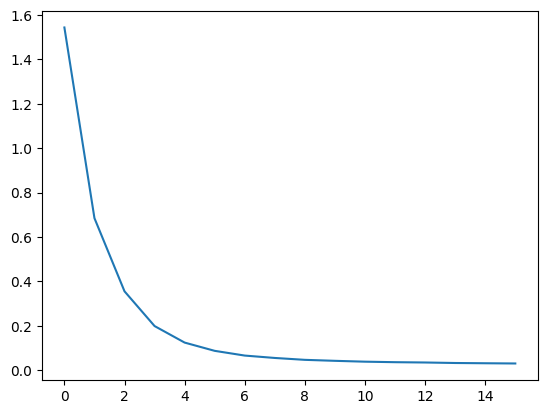

In [24]:
hidden_size = 128

encoder = EncoderGRUNeuralNetwork(input_language.num_words, hidden_size).to(device)
decoder = BahdanauAttentionDecoderGRUNeuralNetwork(hidden_size, output_language.num_words).to(device)

train(train_dataloader, encoder, decoder, num_epochs=80, print_every=5, plot_every=5)

In [32]:
encoder.eval()
decoder.eval()
evaluate_randomly(encoder, decoder)

> il est le plus grand des deux
= he is the taller of the two
< he is the taller of the two <EOS>

> il est fort courageux
= he is very brave
< he is very brave <EOS>

> vous n etes pas encore mort
= you re not dead yet
< you re not dead yet <EOS>

> il est un peu ivre
= he s a bit drunk
< he s a bit drunk <EOS>

> nous n en avons pas termine
= we re not done
< we re not done <EOS>

> je vais avoir besoin de plus de temps
= i m going to need some more time
< i m going to need some more time <EOS>

> vous etes tres astucieuses
= you re very astute
< you re very astute <EOS>

> je requiers ton aide
= i m asking you for your help
< i m asking you for your help <EOS>

> je ne suis pas si presse
= i m not in that much of a hurry
< i m not in that much of a hurry <EOS>

> je suis plutot content
= i m fairly happy
< i m fairly happy <EOS>


Sample Attention:
tensor([[[3.8052e-02, 3.3325e-01, 1.5430e-01, 1.3771e-01, 2.5129e-01,
          2.6021e-02, 2.2861e-02, 1.5383e-02, 1.8317e-02, 2.8240e-03],
         [2.2669e-04, 1.2873e-03, 5.8983e-04, 9.3445e-02, 2.4531e-01,
          1.7962e-01, 1.7801e-01, 1.2158e-01, 1.4049e-01, 3.9445e-02],
         [2.3186e-03, 8.1286e-02, 4.6676e-02, 3.7880e-01, 3.7287e-01,
          4.2105e-02, 4.4898e-02, 1.1891e-02, 1.4720e-02, 4.4345e-03],
         [1.0716e-04, 3.5082e-04, 4.8032e-05, 2.1164e-02, 6.7391e-01,
          9.1989e-02, 6.3175e-02, 7.5774e-02, 5.5719e-02, 1.7765e-02],
         [1.0064e-06, 8.6094e-07, 2.8683e-06, 3.8114e-05, 2.1602e-02,
          2.3130e-01, 2.0626e-01, 2.3559e-01, 2.6166e-01, 4.3544e-02],
         [9.2085e-08, 1.2156e-07, 7.8310e-07, 1.4651e-05, 5.1336e-03,
          3.4612e-02, 2.3286e-01, 3.9058e-01, 2.4398e-01, 9.2816e-02],
         [2.9240e-09, 2.9445e-08, 2.9455e-08, 2.1786e-05, 2.6234e-03,
          5.0081e-03, 3.9052e-03, 3.5720e-01, 4.0450e-01, 2.2675e-

/tmp/ipykernel_567401/1572440452.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
/tmp/ipykernel_567401/1572440452.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


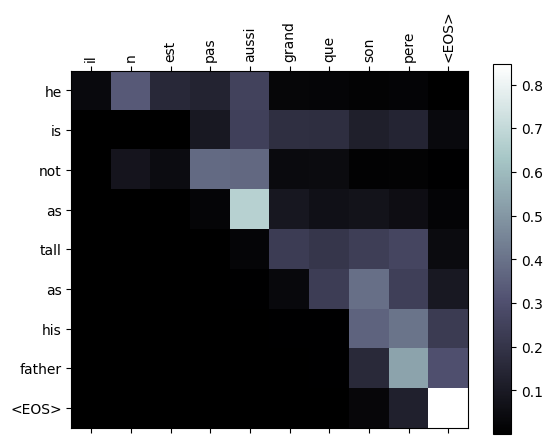

Sample Attention:
tensor([[[4.3554e-01, 3.4978e-02, 1.5061e-01, 1.7389e-01, 5.7214e-02,
          1.3638e-01, 1.1388e-02],
         [4.4103e-04, 2.4309e-04, 1.4897e-01, 6.2378e-01, 1.0226e-02,
          1.9708e-01, 1.9256e-02],
         [3.6976e-04, 3.9402e-04, 9.2100e-01, 6.6431e-02, 1.0558e-02,
          1.0195e-03, 2.2268e-04],
         [3.8476e-04, 1.7453e-04, 1.7084e-02, 8.4998e-01, 7.6120e-02,
          5.0987e-02, 5.2681e-03],
         [3.2406e-06, 1.5784e-06, 2.5433e-04, 5.8591e-02, 2.5236e-01,
          5.9901e-01, 8.9776e-02],
         [5.8227e-08, 5.4780e-08, 3.7763e-05, 6.4751e-02, 2.6292e-02,
          7.2828e-01, 1.8064e-01],
         [6.9161e-08, 2.1063e-08, 1.2070e-05, 1.4800e-03, 6.7318e-04,
          4.7436e-01, 5.2347e-01],
         [1.7623e-08, 1.3590e-08, 1.7409e-05, 1.5054e-03, 5.5899e-04,
          6.9992e-01, 2.9800e-01],
         [1.2136e-08, 5.7767e-08, 1.3048e-04, 2.9330e-02, 1.1816e-03,
          7.1837e-01, 2.5099e-01],
         [4.2042e-08, 3.8790e-07, 6.2

/tmp/ipykernel_567401/1572440452.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
/tmp/ipykernel_567401/1572440452.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


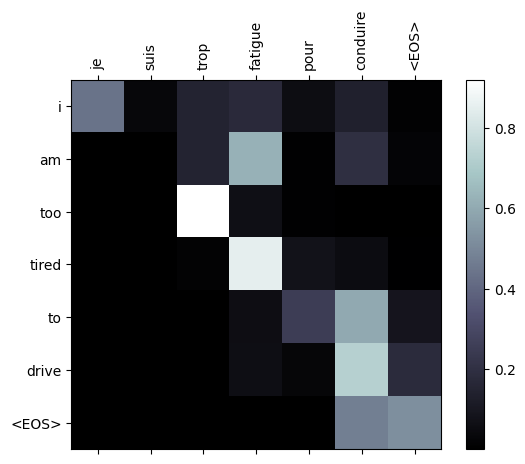

Sample Attention:
tensor([[[4.4646e-01, 7.5509e-02, 2.2904e-01, 1.1369e-01, 4.6290e-02,
          2.7662e-02, 1.3278e-02, 2.6403e-02, 1.7943e-02, 3.7250e-03],
         [6.1199e-05, 3.4543e-05, 9.7702e-02, 5.1603e-01, 5.8891e-02,
          9.1750e-02, 3.6629e-02, 8.4077e-02, 9.5820e-02, 1.9010e-02],
         [1.3093e-04, 2.9958e-04, 6.7707e-01, 3.0907e-01, 3.4263e-03,
          3.0145e-03, 1.4361e-03, 4.4527e-03, 9.1890e-04, 1.8519e-04],
         [4.4561e-06, 2.5824e-06, 4.7770e-03, 5.9482e-01, 1.4016e-01,
          6.7075e-02, 2.9370e-02, 7.5699e-02, 6.9208e-02, 1.8879e-02],
         [1.3148e-04, 3.4638e-05, 4.2033e-03, 8.8291e-02, 3.3482e-01,
          1.4520e-01, 5.8968e-02, 1.6163e-01, 1.6022e-01, 4.6500e-02],
         [2.6767e-07, 4.8416e-08, 3.7955e-04, 1.7293e-02, 7.1557e-02,
          4.5458e-02, 9.6183e-02, 2.5829e-01, 3.8983e-01, 1.2101e-01],
         [3.5214e-06, 3.8356e-07, 8.2853e-04, 2.2998e-02, 1.9928e-02,
          3.8960e-02, 8.5175e-02, 5.1169e-01, 2.4155e-01, 7.8864e-

/tmp/ipykernel_567401/1572440452.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
/tmp/ipykernel_567401/1572440452.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


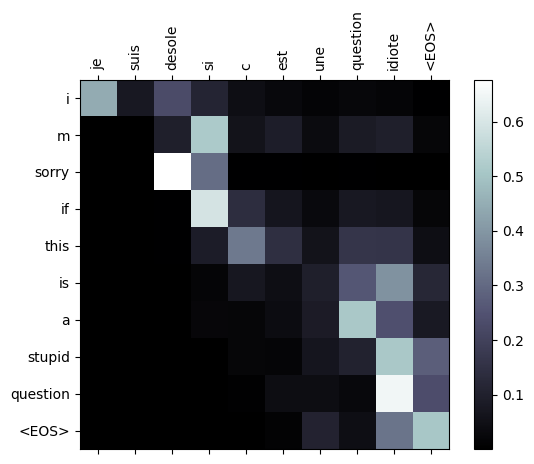

Sample Attention:
tensor([[[5.6678e-01, 5.4391e-02, 1.0181e-01, 1.4862e-01, 5.3501e-02,
          6.4664e-02, 1.0240e-02],
         [4.5626e-04, 1.6115e-04, 7.7397e-02, 5.6768e-01, 6.9028e-02,
          2.1635e-01, 6.8927e-02],
         [1.1521e-04, 2.5682e-04, 6.4028e-01, 3.0824e-01, 3.9454e-02,
          1.1238e-02, 4.1504e-04],
         [5.4609e-05, 5.1073e-06, 1.5508e-02, 7.5872e-01, 1.7726e-01,
          4.1564e-02, 6.8876e-03],
         [3.3952e-04, 3.5322e-05, 3.8563e-03, 1.0088e-01, 2.8000e-01,
          5.0211e-01, 1.1277e-01],
         [1.6078e-07, 9.2564e-08, 1.5715e-04, 6.1031e-03, 1.3506e-01,
          5.9768e-01, 2.6100e-01],
         [1.2991e-07, 6.2935e-08, 1.8821e-04, 2.6679e-03, 5.4962e-02,
          3.8195e-01, 5.6023e-01],
         [1.7365e-08, 3.1211e-09, 6.7585e-05, 4.0400e-04, 6.4256e-04,
          2.6367e-02, 9.7252e-01],
         [9.6447e-09, 1.3819e-08, 1.7543e-05, 5.5388e-04, 8.4358e-03,
          1.1766e-01, 8.7333e-01],
         [8.5280e-09, 1.7578e-08, 4.2

/tmp/ipykernel_567401/1572440452.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
/tmp/ipykernel_567401/1572440452.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


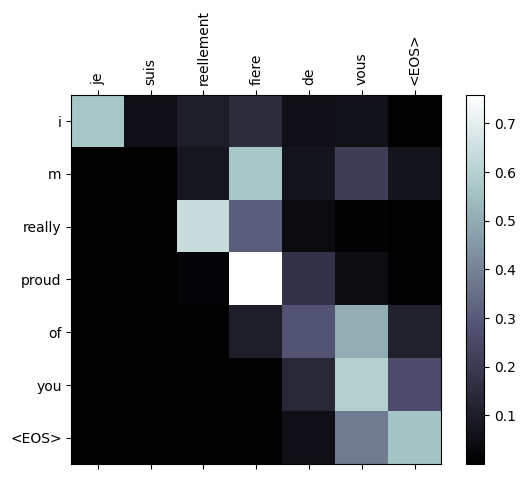

In [59]:
def show_attention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Setup axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    
    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_language, output_language)
    print("Sample Attention:")
    print(attentions)
    print("Attention Shape:", attentions.shape)
    print('Input Sentence:', input_sentence)
    print('output Words:', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions[0, :len(output_words), :])

evaluate_and_show_attention('il n est pas aussi grand que son pere')
evaluate_and_show_attention('je suis trop fatigue pour conduire')
evaluate_and_show_attention('je suis desole si c est une question idiote')
evaluate_and_show_attention('je suis reellement fiere de vous')

# 2. Transformers
- [Attention is All You Need](https://arxiv.org/abs/1706.03762)
- [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/) by Jay Alammar
## 2-1. Multi-Head Self-Attention
As the model processes each word, **Self-Attention** allows it to look at other positions in the input sequence for clues that can help lead to a better encoding for this word. It is the method the Transformer uses to bake the understanding of other relevant words into the one we are currently processing. The steps are as follows:
- Creates three vectors (a **Query Vector**, a **Key Vector** & **a Value Vector**) from each of the encoder's input vectors (the embedding of each word). These vectors are created by multiplying the embedding by three matrices that we trained during the training process. They are usually smaller in dimension than the embedding vector.
- Calculates scores by taking the dot product of the query vector with the key vector of the respective word we are scoring.
- Divides the scores by the square root of the dimension of the key vectors. This leads to having more stable gradients.
- Passes the result through a softmax operation for normalization so that they are all positive & add up to $1$. This softmax score determines how much each word will be expressed at this position.
- Multiplies each value vector by the softmax score. Keeps intact the values of the words we want to focus on & drown-out irrelevant words.
- Sums up the weighted value vectors. Produces the output of the self-attention layer at this position for the first word.

**Multi-Head Attention** is a module for attention mechanisms which runs through an attention mechanism several times in parallel. The independent attention outputs are then concatenated and linearly transformed into the expected dimension. Multiple attention heads allows for attending to parts of the sequence differently, such as longer-term dependencies versus shorter-term dependencies.

1. `torch.Tensor.masked_fill(mask, value)`: Fills elements of `self` tensor with `value` where `mask` is `True`. The shape of `mask` must be broadcastable with the shape of the underlying tensor.

- [Masked Attention](https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture)#Masked_attention)

In [17]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, dim_k, dim_model, num_heads, maximum_length, causal=False):
        super().__init__()
    
        # Assume `dim_v = dim_k`
        self.dim_k = dim_k
        self.num_heads = num_heads
    
        self.key = torch.nn.Linear(dim_model, dim_k * num_heads)
        self.query = torch.nn.Linear(dim_model, dim_k * num_heads)
        self.value = torch.nn.Linear(dim_model, dim_k * num_heads)
    
        # Final linear layer
        self.linear = torch.nn.Linear(dim_k * num_heads, dim_model)
    
        # Causal mask 
        # Make it so that diagonal is `0` too
        # This way we don't have to shift the inputs to make targets
        self.causal = causal
        if causal:
            causal_mask = torch.tril(torch.ones(maximum_length, maximum_length))
            self.register_buffer("causal_mask", causal_mask.view(1, 1, maximum_length, maximum_length))

    def forward(self, q, k, v, pad_mask=None):
        # `N` is batch size; `T` means 
        # `(N, T, h * dim_k)`
        q = self.query(q)
        # `(N, T, h * dim_k)`
        k = self.key(k)
        # `(N, T, h * dim_v)`
        v = self.value(v)
    
        N = q.shape[0]
        T_output = q.shape[1]
        T_input = k.shape[1]
    
        # Change the shape from `(N, T, h, dim_k)` to `(N, h, T, dim_k)` in order for matrix multiplication to work properly
        q = q.view(N, T_output, self.num_heads, self.dim_k).transpose(1, 2)
        k = k.view(N, T_input, self.num_heads, self.dim_k).transpose(1, 2)
        v = v.view(N, T_input, self.num_heads, self.dim_k).transpose(1, 2)
    
        # Compute attention weights
        # `(N, h, T, d_k)` x `(N, h, d_k, T)` to `(N, h, T, T)`
        attn_scores = q @ k.transpose(-2, -1) / math.sqrt(self.dim_k)
        if pad_mask is not None:
            # `(N, T)` to `(N, 1, 1, T)`; Use `float('-inf')` because the result it takes softmax is `0`
            attn_scores = attn_scores.masked_fill(pad_mask[:, None, None, :] == 0, float('-inf'))
        if self.causal:
            attn_scores = attn_scores.masked_fill(self.causal_mask[:, :, :T_output, :T_input] == 0, float('-inf'))
        attn_weights = torch.nn.functional.softmax(attn_scores, dim=-1)
        
        # Compute attention-weighted values: `(N, h, T, T)` x `(N, h, T, dim_k)` to `(N, h, T, dim_k)`
        A = attn_weights @ v
    
        # Reshape it back before final linear layer
        # `(N, T, h, dim_k)`
        A = A.transpose(1, 2)
        # `(N, T, h * dim_k)`
        A = A.contiguous().view(N, T_output, self.dim_k * self.num_heads) 
    
        # Projection
        return self.linear(A)

In [3]:
class EncoderBlock(nn.Module):
    def __init__(self, dim_k, dim_model, num_heads, maximum_length, dropout_prob=0.1):
        super().__init__()
    
        self.layer_norm_1 = torch.nn.LayerNorm(dim_model)
        self.layer_norm_2 = torch.nn.LayerNorm(dim_model)
        self.multi_head_attn = MultiHeadAttention(dim_k, dim_model, num_heads, maximum_length, causal=False)
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(dim_model, dim_model * 4),
            torch.nn.GELU(),
            torch.nn.Linear(dim_model * 4, dim_model),
            torch.nn.Dropout(dropout_prob),
        )
        self.dropout = torch.nn.Dropout(p=dropout_prob)
  
    def forward(self, X, pad_mask=None):
        X = self.layer_norm_1(X + self.multi_head_attn(X, X, X, pad_mask))
        X = self.layer_norm_2(X + self.linear(X))
        X = self.dropout(X)
        return X

## 2-2. Sinusoidal Positional Encoding
**Positional Encoding** describes the location or position of an entity in a sequence so that each position is assigned a unique representation. The following criteria should be satisfied:
- It should output a unique encoding for each time step (word’s position in a sentence).
- Distance between any two time steps should be consistent across sentences with different lengths.
- Our model should generalize to longer sentences without any efforts. Its values should be bounded.
- It must be deterministic.

**Sinusoidal Positional Encoding (SPE)** is the first proposed method.

In [4]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, dim_model, maximum_length=2048, dropout_prob=0.1):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout_prob)
    
        position = torch.arange(maximum_length).unsqueeze(1)
        power_term = torch.arange(0, dim_model, 2)
        # We take advantage of the property `exp(-ylog(x)) = 1 / (x^y)`  
        denominator_term = torch.exp(power_term * (-math.log(10000.0) / dim_model))
        positional_encoding = torch.zeros(1, maximum_length, dim_model)
        positional_encoding[0, :, 0::2] = torch.sin(position * denominator_term)
        positional_encoding[0, :, 1::2] = torch.cos(position * denominator_term)
        self.register_buffer('positional_encoding', positional_encoding)

    def forward(self, X):
        # `(N, T, D)`
        X = X + self.positional_encoding[:, :X.size(1), :]
        return self.dropout(X)

## 2-3. Text Classification with Transformer Encoders
Use GLUE SST-2.

In [5]:
class Encoder(torch.nn.Module):
    def __init__(self, vocab_size, maximum_length, dim_k, dim_model, num_heads, num_layers, num_classes, dropout_prob):
        super().__init__()
    
        self.embedding = torch.nn.Embedding(vocab_size, dim_model)
        self.positional_encoding = PositionalEncoding(dim_model, maximum_length, dropout_prob)
        transformer_blocks = [EncoderBlock(dim_k, dim_model, num_heads, maximum_length, dropout_prob) for _ in range(num_layers)]
        self.transformer_blocks = torch.nn.Sequential(*transformer_blocks)
        self.layer_norm = torch.nn.LayerNorm(dim_model)
        self.linear = torch.nn.Linear(dim_model, num_classes)
  
    def forward(self, X, pad_mask=None):
        X = self.embedding(X)
        X = self.positional_encoding(X)
        for block in self.transformer_blocks:
            # print(block)
            X = block(X, pad_mask)
    
        # Many-to-one (X has the shape N x T x D)
        X = X[:, 0, :]
    
        X = self.layer_norm(X)
        X = self.linear(X)
        return X

In [6]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

encoder = Encoder(vocab_size=20_000, maximum_length=1024, dim_k=16, dim_model=64, num_heads=4, num_layers=2, num_classes=5, dropout_prob=0.1)

# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
encoder.to(device)

cuda


Encoder(
  (embedding): Embedding(20000, 64)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): EncoderBlock(
      (layer_norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (layer_norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (multi_head_attention): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (linear): Linear(in_features=64, out_features=64, bias=True)
      )
      (linear): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=256, out_features=64, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): EncoderBlock(


In [7]:
import numpy as np

np.random.seed(0)
X = np.random.randint(0, 20_000, size=(8, 512))
X = torch.tensor(X).to(device)

mask = np.ones((8, 512))
mask[:, 256:] = 0
mask = torch.tensor(mask).to(device)

y = encoder(X, mask)
y.shape

torch.Size([8, 5])

In [8]:
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset

checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

raw_dataset = load_dataset("glue", "sst2")
print(raw_dataset)

2024-09-27 10:07:10.123882: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-27 10:07:10.131370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 10:07:10.139767: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 10:07:10.142248: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 10:07:10.149278: I tensorflow/core/platform/cpu_feature_guar

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})


In [9]:
def tokenize(batch):
    return tokenizer(batch['sentence'], truncation=True)

tokenized_dataset = raw_dataset.map(tokenize, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
print(data_collator)

DataCollatorWithPadding(tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')


In [10]:
print(tokenized_dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 1821
    })
})


In [11]:
tokenized_dataset = tokenized_dataset.remove_columns(["sentence", "idx"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
print(tokenized_dataset)

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1821
    })
})


In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    tokenized_dataset["train"],
    shuffle=True,
    batch_size=32,
    collate_fn=data_collator
)
valid_loader = DataLoader(
    tokenized_dataset["validation"],
    batch_size=32,
    collate_fn=data_collator
)

# Check how it works
for batch in train_loader:
    for k, v in batch.items():
        print("k:", k, "v.shape:", v.shape)
    break

k: labels v.shape: torch.Size([32])
k: input_ids v.shape: torch.Size([32, 43])
k: attention_mask v.shape: torch.Size([32, 43])


In [13]:
print("Labels in the Tokenized Dataset:", set(tokenized_dataset['train']['labels']))
print("Vocabulary Size:", tokenizer.vocab_size)
print("Model Maximum Length:", tokenizer.model_max_length)

Labels in the Tokenized Dataset: {0, 1}
Vocabulary Size: 28996
Model Maximum Length: 512


In [14]:
encoder = Encoder(vocab_size=tokenizer.vocab_size, maximum_length=tokenizer.model_max_length, dim_k=16, dim_model=64, num_heads=4, num_layers=2, num_classes=2, dropout_prob=0.1)
encoder.to(device)

Encoder(
  (embedding): Embedding(28996, 64)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): EncoderBlock(
      (layer_norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (layer_norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (multi_head_attention): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (linear): Linear(in_features=64, out_features=64, bias=True)
      )
      (linear): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=256, out_features=64, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): EncoderBlock(


In [15]:
from datetime import datetime

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(encoder.parameters())

# A function to encapsulate the training loop
def train(model, criterion, optimizer, train_loader, valid_loader, num_epochs):
    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        model.train()
        t_0 = datetime.now()
        train_loss = 0
        num_train = 0
        for batch in train_loader:
            # Move data to GPU
            batch = {k: v.to(device) for k, v in batch.items()}
        
            # zero the parameter gradients
            optimizer.zero_grad()
        
            # Forward pass
            outputs = model(batch['input_ids'], batch['attention_mask'])
            loss = criterion(outputs, batch['labels'])
                
            # Backward and optimize
            loss.backward()
            optimizer.step()
        
            train_loss += loss.item() * batch['input_ids'].size(0)
            num_train += batch['input_ids'].size(0)
    
        # Get average train loss
        train_loss = train_loss / num_train
    
        model.eval()
        test_loss = 0
        num_test = 0
        for batch in valid_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(batch['input_ids'], batch['attention_mask'])
            loss = criterion(outputs, batch['labels'])
            test_loss += loss.item() * batch['input_ids'].size(0)
            num_test += batch['input_ids'].size(0)
        test_loss = test_loss / num_test
    
        # Save losses
        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss
        
        d_t = datetime.now() - t_0
        print(f'Epoch {epoch + 1} / {num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {d_t}')
  
    return train_losses, test_losses

train_losses, test_losses = train(encoder, criterion, optimizer, train_loader, valid_loader, num_epochs=4)

Epoch 1 / 4, Train Loss: 0.5335, Test Loss: 0.4901, Duration: 0:00:05.956681
Epoch 2 / 4, Train Loss: 0.3705, Test Loss: 0.4639, Duration: 0:00:05.120563
Epoch 3 / 4, Train Loss: 0.3001, Test Loss: 0.4533, Duration: 0:00:06.071800
Epoch 4 / 4, Train Loss: 0.2599, Test Loss: 0.4942, Duration: 0:00:05.040054


In [16]:
# Accuracy
encoder.eval()
num_correct = 0.
num_total = 0.
for batch in train_loader:
    # Move to GPU
    batch = {k: v.to(device) for k, v in batch.items()}

    # Forward pass
    outputs = encoder(batch['input_ids'], batch['attention_mask'])

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
  
    # update counts
    num_correct += (predictions == batch['labels']).sum().item()
    num_total += batch['labels'].shape[0]

train_acc = num_correct / num_total

num_correct = 0.
num_total = 0.
for batch in valid_loader:
    # Move to GPU
    batch = {k: v.to(device) for k, v in batch.items()}
  
    # Forward pass
    outputs = encoder(batch['input_ids'], batch['attention_mask'])

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
  
    # update counts
    num_correct += (predictions == batch['labels']).sum().item()
    num_total += batch['labels'].shape[0]

test_acc = num_correct / num_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9298, Test acc: 0.7856


## 2-4. Text Classification with Transformer Decoders

In [19]:
class DecoderBlock(nn.Module):
    def __init__(self, dim_k, dim_model, num_heads, maximum_length, dropout_prob=0.1):
        super().__init__()
    
        self.layer_norm_1 = torch.nn.LayerNorm(dim_model)
        self.layer_norm_2 = torch.nn.LayerNorm(dim_model)
        self.layer_norm_3 = torch.nn.LayerNorm(dim_model)
        self.multi_head_attn_1 = MultiHeadAttention(dim_k, dim_model, num_heads, maximum_length, causal=True)
        self.multi_head_attn_2 = MultiHeadAttention(dim_k, dim_model, num_heads, maximum_length, causal=False)
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(dim_model, dim_model * 4),
            torch.nn.GELU(),
            torch.nn.Linear(dim_model * 4, dim_model),
            torch.nn.Dropout(p=dropout_prob),
        )
        self.dropout = torch.nn.Dropout(p=dropout_prob)
  
    def forward(self, encoder_output, decoder_input, encoder_mask=None, decoder_mask=None):
        # Self-attention on decoder input
        X = self.layer_norm_1(decoder_input + self.multi_head_attn_1(decoder_input, decoder_input, decoder_input, decoder_mask))
    
        # Multi-head attention including encoder output
        X = self.layer_norm_2(X + self.multi_head_attn_2(X, encoder_output, encoder_output, encoder_mask))
    
        X = self.layer_norm_3(X + self.linear(X))
        X = self.dropout(X)
        return X

In [20]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, maximum_length, dim_k, dim_model, num_heads, num_layers, dropout_prob):
        super().__init__()
    
        self.embedding = torch.nn.Embedding(vocab_size, dim_model)
        self.positional_encoding = PositionalEncoding(dim_model, maximum_length, dropout_prob)
        transformer_blocks = [DecoderBlock(dim_k, dim_model, num_heads, maximum_length, dropout_prob) for _ in range(num_layers)]
        self.transformer_blocks = torch.nn.Sequential(*transformer_blocks)
        self.layer_norm = torch.nn.LayerNorm(dim_model)
        self.linear = torch.nn.Linear(dim_model, vocab_size)
  
    def forward(self, encoder_output, decoder_input, encoder_mask=None, decoder_mask=None):
        X = self.embedding(decoder_input)
        X = self.positional_encoding(X)
        for block in self.transformer_blocks:
            X = block(encoder_output, X, encoder_mask, decoder_mask)
        X = self.layer_norm(X)
        # Many-to-many
        X = self.linear(X) 
        return x

In [23]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

decoder = Decoder(vocab_size=20_000, maximum_length=1024, dim_k=16, dim_model=64, num_heads=4, num_layers=2, dropout_prob=0.1)

# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
decoder.to(device)

cuda


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import numpy as np

np.random.seed(0)
X = np.random.randint(0, 20_000, size=(8, 512))
X = torch.tensor(X).to(device)

mask = np.ones((8, 512))
mask[:, 256:] = 0
mask = torch.tensor(mask).to(device)

y = decoder(X, mask)
y.shape

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset

checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Use the same dataset but ignore the labels
raw_datasets = load_dataset("glue", "sst2")
print(raw_datasets)

In [ ]:
def tokenize(batch):
   return tokenizer(batch['sentence'], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
print(tokenized_datasets)

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(["sentence", "idx", "label"])
print(tokenized_datasets)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=32, collate_fn=data_collator)

# check how it works
for batch in train_loader:
    for k, v in batch.items():
        print("k:", k, "v.shape:", v.shape)
    break

print(tokenizer.pad_token_id)

In [ ]:
decoder = Decoder(vocab_size=tokenizer.vocab_size, maximum_length=tokenizer.model_max_length, dim_k=16, dim_model=64, num_heads=4, num_layers=2, dropout_prob=0.1)
decoder.to(device)

In [ ]:
from datetime import datetime

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.Adam(decoder.parameters())

# A function to encapsulate the training loop
def train(model, criterion, optimizer, train_loader, num_epochs):
    train_losses = np.zeros(epochs)

    for it in range(epochs):
        model.train()
        t_0 = datetime.now()
        train_loss = []
        for batch in train_loader:
            # move data to GPU
            batch = {k: v.to(device) for k, v in batch.items()}
    
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # shift targets backwards
            targets = batch['input_ids'].clone().detach()
            targets = torch.roll(targets, shifts=-1, dims=1)
            targets[:, -1] = tokenizer.pad_token_id
    
            # Forward pass
            outputs = model(batch['input_ids'], batch['attention_mask'])
            # outputs are (N, T, V)
            # but PyTorch expects (N, V, T)
            # print("outputs:", outputs)
            # print("targets:", targets)
            loss = criterion(outputs.transpose(2, 1), targets)
            # N, T, V = outputs.shape
            # loss = criterion(outputs.view(N * T, V), targets.view(N * T))
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        # Get train loss and test loss
        train_loss = np.mean(train_loss)
    
        # Save losses
        train_losses[it] = train_loss
        
        d_t = datetime.now() - t_0
        print(f'Epoch {it + 1} / {num_epochs}, Train Loss: {train_loss:.4f}, Duration: {dt}')
        
  return train_losses

train_losses = train(decoder, criterion, optimizer, train_loader, epochs=15)

In [ ]:
valid_loader = DataLoader(tokenized_datasets["validation"], batch_size=1, collate_fn=data_collator)

decoder.eval()
for batch in valid_loader:
    # move data to GPU
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = decoder(batch['input_ids'], batch['attention_mask'])
    break

print(outputs.shape)
print(torch.argmax(outputs, axis=-1))

prediction_ids = torch.argmax(outputs, axis=-1)
print(tokenizer.decode(prediction_ids[0]))

print(tokenizer.decode(batch['input_ids'][0]))
print(tokenizer.decode(torch.concat((batch['input_ids'][0, :5], prediction_ids[:, 4]))))

In [ ]:
# generate something
prompt = "it's"

tokenized_prompt = tokenizer(prompt, return_tensors='pt')
print(tokenized_prompt)

In [ ]:
outputs = model(tokenized_prompt['input_ids'][:, :-1].to(device), tokenized_prompt['attention_mask'][:, :-1].to(device))
print(outputs.shape)

prediction_ids = torch.argmax(outputs[:, -1, :], axis=-1)
print(tokenizer.decode(prediction_ids[0]))

In [ ]:
# generate something
prompt = "it's a"

tokenized_prompt = tokenizer(prompt, return_tensors='pt')

# Prepare inputs & get rid of `<SEP>` token at the end
input_ids = tokenized_prompt['input_ids'][:, :-1].to(device)
mask = tokenized_prompt['attention_mask'][:, :-1].to(device)

for _ in range(20):
    outputs = decoder(input_ids, mask)
    prediction_id = torch.argmax(outputs[:, -1, :], axis=-1)

    input_ids = torch.hstack((input_ids, prediction_id.view(1, 1)))
    mask = torch.ones_like(input_ids)

    if prediction_id == tokenizer.sep_token_id:
        break

tokenizer.decode(input_ids[0])

## 2-5. Text Classification with Transformers

In [ ]:
class Transformer(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
  
  def forward(self, enc_input, dec_input, enc_mask, dec_mask):
    enc_output = self.encoder(enc_input, enc_mask)
    dec_output = self.decoder(enc_output, dec_input, enc_mask, dec_mask)
    return dec_output

In [ ]:
# test it
encoder = Encoder(vocab_size=20_000,
                  max_len=512,
                  d_k=16,
                  d_model=64,
                  n_heads=4,
                  n_layers=2,
                  dropout_prob=0.1)
decoder = Decoder(vocab_size=10_000,
                  max_len=512,
                  d_k=16,
                  d_model=64,
                  n_heads=4,
                  n_layers=2,
                  dropout_prob=0.1)
transformer = Transformer(encoder, decoder)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
encoder.to(device)
decoder.to(device)

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, vocab_size, maximum_length, dim_k, dim_model, num_heads, num_layers, dropout_prob):
        super().__init__()
    
        self.embedding = torch.nn.Embedding(vocab_size, dim_model)
        self.position_encoding = PositionalEncoding(dim_model, maximum_length, dropout_prob)
        transformer_blocks = [EncoderBlock(dim_k, dim_model, num_heads, maximum_length, dropout_prob) for _ in range(n_layers)]
        self.transformer_blocks = torch.nn.Sequential(*transformer_blocks)
        self.layer_norm = torch.nn.LayerNorm(dim_model)
        # self.linear = nn.Linear(dim_model, num_classes)
  
    def forward(self, x, pad_mask=None):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        for block in self.transformer_blocks:
          x = block(x, pad_mask)
    
        # many-to-one (x has the shape N x T x D)
        # x = x[:, 0, :]
    
        x = self.ln(x)
        # x = self.fc(x)
        return x

# 4. Transfer Learning

In [ ]:
# [1] Freeze weights
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [ ]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer (using SGD to slow down learning!)
  optimizer = torch.optim.SGD(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# inspect the "learning toggle" of a layer
N = createTheMNISTNet()[0]
N.fc1.weight.requires_grad

In [ ]:
N = createTheMNISTNet()[0]

# switch off all layers except input
for p in N.named_parameters():
  if 'input' not in p[0]:
    p[1].requires_grad = False
  

# check what we've done
for p in N.named_parameters():
  print('Requires_grad status in layer %s: %s' %(p[0],p[1].requires_grad))

In [ ]:
def function2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 100
  
  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):



    
    # NEW: switch off learning in all-but-output layers during first 1/2 of training
    if epochi<(numepochs/2):
      for p in net.named_parameters():
        if 'output' not in p[0]:
          p[1].requires_grad = False
    else:
      for p in net.named_parameters():
        p[1].requires_grad = True
    
    



    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [ ]:
# create the network
net,lossfun,optimizer = createTheMNISTNet()

# train the model
trainAcc,testAcc,losses,net = function2trainTheModel(net,lossfun,optimizer)

plt.plot(trainAcc,label='Train')
plt.plot(testAcc,label='Test')
plt.plot([len(trainAcc)/2, len(trainAcc)/2],[10,80],'k--',label='Learning switched on')
plt.legend()
plt.show()

## 4-2. Transformers

- [Supported Models & Frameworks](https://huggingface.co/docs/transformers/index#supported-models-and-frameworks)
### 4-2-1. Pipelines
- [Complete List of Supported Tasks](https://huggingface.co/docs/transformers/v4.44.0/en/main_classes/pipelines#transformers.pipeline)

In [3]:
#!pip3 install tf-keras 
from transformers import pipeline

In [4]:
classifier = pipeline("sentiment-analysis")
type(classifier)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


transformers.pipelines.text_classification.TextClassificationPipeline

In [5]:
# Output is a dictionary
classifier("This is such a great movie!")

[{'label': 'POSITIVE', 'score': 0.9998759031295776}]

### 4-2-2. Fine-Tuning

In [6]:
from datasets import load_dataset

In [7]:
raw_datasets = load_dataset("glue", "sst2")
raw_datasets

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [8]:
raw_datasets['train']

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 67349
})

In [9]:
raw_datasets['train'].data

MemoryMappedTable
sentence: string
label: int64
idx: int32
----
sentence: [["hide new secretions from the parental units ","contains no wit , only labored gags ","that loves its characters and communicates something rather beautiful about human nature ","remains utterly satisfied to remain the same throughout ","on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ",...,"you wish you were at home watching that movie instead of in the theater watching this one ","'s no point in extracting the bare bones of byatt 's plot for purposes of bland hollywood romance ","underdeveloped ","the jokes are flat ","a heartening tale of small victories "],["suspense , intriguing characters and bizarre bank robberies , ","a gritty police thriller with all the dysfunctional family dynamics one could wish for ","with a wonderful ensemble cast of characters that bring the routine day to day struggles of the working class to life ","nonetheless appreciates the art and reveals a music sc

In [44]:
raw_datasets['train'].features

{'sentence': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'positive'], id=None),
 'idx': Value(dtype='int32', id=None)}

In [10]:
from transformers import AutoTokenizer
from pprint import pprint

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenized_sentences = tokenizer(raw_datasets['train'][0:3]['sentence'])
pprint(tokenized_sentences)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'input_ids': [[101, 5342, 2047, 3595, 8496, 2013, 1996, 18643, 3197, 102],
               [101,
                3397,
                2053,
                15966,
                1010,
                2069,
                4450,
                2098,
                18201,
                2015,
                102],
               [101,
                2008,
                7459,
                2049,
                3494,
                1998,
                10639,
                2015,
                2242,
                2738,
                3376,
                2055,
                2529,
                3267,
                102]]}


In [19]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)
type(tokenized_datasets)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

datasets.dataset_dict.DatasetDict

In [13]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  'my_trainer',
  eval_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=1,
)
training_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False,
evaluation_s

In [12]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=2)
type(model)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification

In [14]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [15]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           1,538
├─Dropout: 1-4                                          --
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0

In [32]:
# !pip3 install evaluate
import evaluate

# Metric for validation error
def compute_metrics(eval_preds):
    metric = load_metric("glue", "sst2")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [33]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.151100,0.509155,0.883028


TrainOutput(global_step=8419, training_loss=0.07386701579104694, metrics={'train_runtime': 194.6434, 'train_samples_per_second': 346.012, 'train_steps_per_second': 43.253, 'total_flos': 517212489917652.0, 'train_loss': 0.07386701579104694, 'epoch': 1.0})

In [34]:
trainer.save_model('models/finetuned_model')

In [35]:
finetuned_model = pipeline("sentiment-analysis", model='models/finetuned_model', device=0)
finetuned_model('This is such a great movie!')

[{'label': 'LABEL_1', 'score': 0.9997863173484802}]

In [41]:
finetuned_model('This is such a bad movie!')

[{'label': 'LABEL_0', 'score': 0.9997292160987854}]

In [36]:
!cat models/finetuned_model/config.json

{
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.43.4",
  "vocab_size": 30522
}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [58]:
metric = load_metric("glue", "sst2")

n_samples = 500

# The labels in test set of `glue/sst2` are `-1`
X = raw_datasets['train'].data["sentence"].to_pylist()[:n_samples]
y = raw_datasets['train'].data["label"].to_pylist()[:n_samples]

results = finetuned_model(X)
predictions = [0 if res["label"] == "LABEL_0" else 1 for res in results]
print(metric.compute(predictions=predictions, references=y))

{'accuracy': 0.988}
